In [17]:
import torch
from torch.utils.data import DataLoader
import pandas as pd
import random
import numpy as np
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
import ipdb
import re
import umap

from sklearn.manifold import TSNE



import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='darkgrid', context='notebook', rc={'figure.figsize':(14,10)}, font_scale=2.5)

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

device = torch.device('cpu')

# Set random seeds for reproducibility on a specific machine
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.manual_seed(1)
torch.cuda.manual_seed(1)
random.seed(1)
np.random.seed(1)
np.random.RandomState(1)

RandomState(MT19937) at 0x7FBC2C68D740

In [3]:
# Load model
model = AutoModel.from_pretrained("vinai/bertweet-base")
model.eval()
# Load the AutoTokenizer with a normalization mode if the input Tweet is raw
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
emoji is not installed, thus not converting emoticons or emojis into text. Please install emoji: pip3 install emoji
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
# Load tweet data
maj_df = pd.read_csv('../../data-annotation/maj_df_split.tsv', sep='\t')

In [5]:
maj_df

,TweetId,tweet,username,mentname,Date,Predom,Feeling,Behavior,Admiration,Admiration_Int,Anger,Anger_Int,Disgust,Disgust_Int,Fear,Fear_Int,Interest,Interest_Int,Joy,Joy_Int,Sadness,Sadness_Int,Surprise,Surprise_Int,group,party,Split
0,1001885064974790657,Admire @OfficialCBC Chairman @reprichmond's moral voice on issues of racism and restorative justice. He is a real leader for our nation and Congress.,reprokhanna,reprichmond,2018-05-30,predom,warm,app,True,3.000000,False,2.000000,False,2.000000,False,2.0,False,2.333333,False,2.000000,False,2.0,False,2.0,1,D,train
1,1002970603165536258,It was wonderful to celebrate the 150th anniversary of Washington’s Pilotage Act this week with @pattymurray and this fantastic group in Port Townsend.,senatorcantwell,pattymurray,2018-06-02,predom,warm,app,False,2.000000,False,2.000000,False,2.000000,False,2.0,False,2.000000,True,2.333333,False,2.0,False,2.0,1,D,test
2,1003713413292462082,"I’m proud to support legislation Senator @timkaine introduced to protect children if they are separated from their parents, and I’m going to continue looking at what else we can to do end the Trump Administration's deeply wrong policy.",pattymurray,timkaine,2018-06-04,predom,warm,app,False,2.333333,False,2.000000,False,2.000000,False,2.0,False,2.000000,True,2.333333,False,2.0,False,2.0,1,D,train
3,1004419010333691904,"During #ImmigrantHeritageMonth, let’s remember the numerous contributions those “yearning to breathe free” have made to our nation, and do the people’s work by voting on bipartisan immigration reform measures. No more excuses, @speakerryan. #CelebrateImmigrants!",repdelbene,speakerryan,2018-06-06,predom,cold,disapp,False,2.000000,True,2.000000,False,2.333333,False,2.0,False,2.000000,False,2.000000,False,2.0,False,2.0,-1,D,train
4,1004433631950065664,Thank you @senatorleahy. The Administration is choosing to implement an inhuman policy that separates migrant children from their parents. It must end now!,senbobcasey,senatorleahy,2018-06-06,predom,warm,app,True,2.000000,False,2.000000,False,2.000000,False,2.0,False,2.000000,True,1.666667,False,2.0,False,2.0,1,D,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3028,999245047202811904,.@stevekingia should keep his eyes and “ears” on the corn in Iowa and leave Mayor Schaaf to continue ably serving her Oakland constituents.,repspeier,stevekingia,2018-05-23,predom,cold,disapp,False,2.000000,True,2.333333,True,2.333333,False,2.0,False,2.000000,False,2.000000,False,2.0,False,2.0,-1,D,train
3029,999289718683721728,"We’ve lost 630,000 Americans to overdoses since 2000. We're in the midst of an #OpioidEpidemic. The House will soon consider more than 60 bills to combat this epidemic because we can’t let opioids continue to ravage our communities. More from @gopleader:",speakerryan,gopleader,2018-05-23,predom,neutral,dunno,False,2.000000,False,2.000000,False,2.000000,False,2.0,True,2.333333,False,2.000000,False,2.0,False,2.0,1,R,train
3030,999329645316247552,The House approved an amendment to the National Defense Authorization Act that I sponsored along with @gracenapolitano supporting the National Guard Youth Challenge program. Read more here:,kencalvert,gracenapolitano,2018-05-23,predom,warm,app,False,2.000000,False,2.000000,False,2.000000,False,2.0,False,2.000000,False,2.000000,False,2.0,False,2.0,-1,R,train
3031,999381351634743299,Led a letter to President Trump with @mikekellypa and 78 other members to ensure the government protects faith-based organizations that provide child welfare services from losing federal funding because of their religious faith.,senatorenzi,mikekellypa,2018-05-23,predom,warm,app,False,2.000000,False,2.000000,False,2.000000,False,2.0,False,2.000000,False,1.666667,False,2.0,False,2.0,1,R,test


In [6]:
def replace_ent(tweet, ent):
    'Find entity name in tweet and replace with Doe' 
    
    pattern = re.compile(r"\@" + ent, re.IGNORECASE)
    return re.sub(pattern, "@Doe", tweet)

maj_df['tweet_clean'] = maj_df.apply(lambda x: replace_ent(tweet=x['tweet'], ent=x['mentname']), axis=1)

In [7]:
tweetso = maj_df['tweet'].tolist()
tweets = maj_df['tweet_clean'].tolist()
party = maj_df['party'].tolist()
group = maj_df['group'].tolist()
beh = maj_df['Behavior'].tolist()
fel = maj_df['Feeling'].tolist()
authors = maj_df['username'].tolist()

In [8]:
# for _, tweet in enumerate(tqdm(tweets)):
#     input_ids = tokenizer(tweet, add_special_tokens=True, return_tensors='pt', return_token_type_ids = False, 
#                          return_attention_mask=False)['input_ids']
#     output = model(input_ids)
#     cls_vector = output[0][:,0,:].detach().numpy()
#     if _ == 0:
#         cls_tensors = cls_vector
#     else:
#         cls_tensors = np.append(cls_tensors, cls_vector, axis=0)

# with open('cls_vectors.npy', 'wb') as f:
#     np.save(f, cls_tensors)

In [9]:
cls_tensors = np.load('cls_vectors.npy')

In [10]:
cls_tensors.shape

(3033, 768)

In [11]:

n_neighbors = 15
min_dist = 1
n_components = 2
metric = 'euclidean'

In [12]:
reducer = umap.UMAP(n_neighbors=n_neighbors,
                    min_dist=min_dist,
                    n_components=n_components,
                    metric=metric,
                    verbose=True)
embedding = reducer.fit_transform(cls_tensors)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


UMAP(min_dist=1, verbose=True)
Tue May 17 08:59:02 2022 Construct fuzzy simplicial set
Tue May 17 08:59:07 2022 Finding Nearest Neighbors
Tue May 17 08:59:08 2022 Finished Nearest Neighbor Search
Tue May 17 08:59:10 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue May 17 08:59:15 2022 Finished embedding


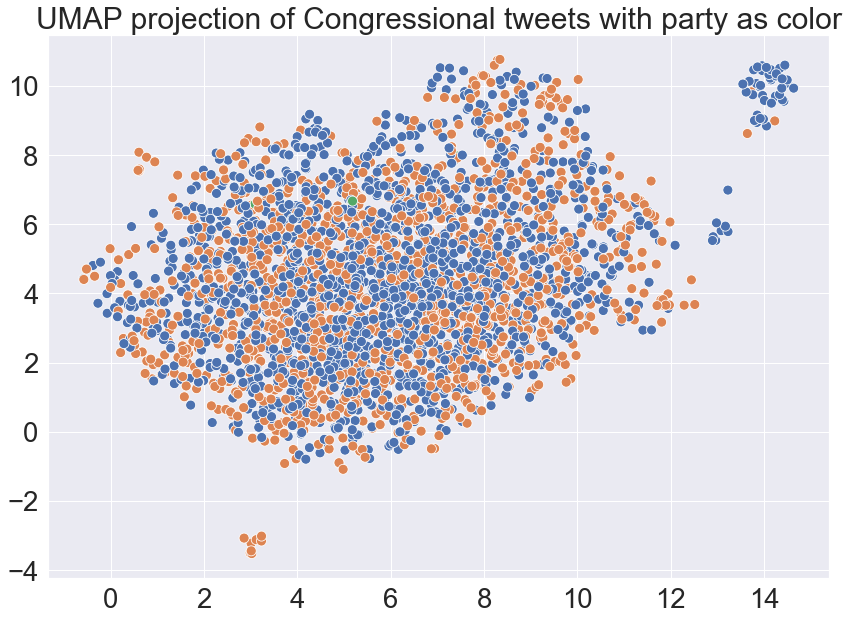

In [13]:
ax=sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=party, s=100)
plt.title('UMAP projection of Congressional tweets with party as color')
_lg = ax.get_legend()
_lg.remove()

In [14]:
emot_ans = ['Admiration', 'Disgust', 'Anger', 'Interest', 'Joy', 'Sadness']

In [15]:
emots_dict = {e:maj_df.loc[:, e] for e in emot_ans}

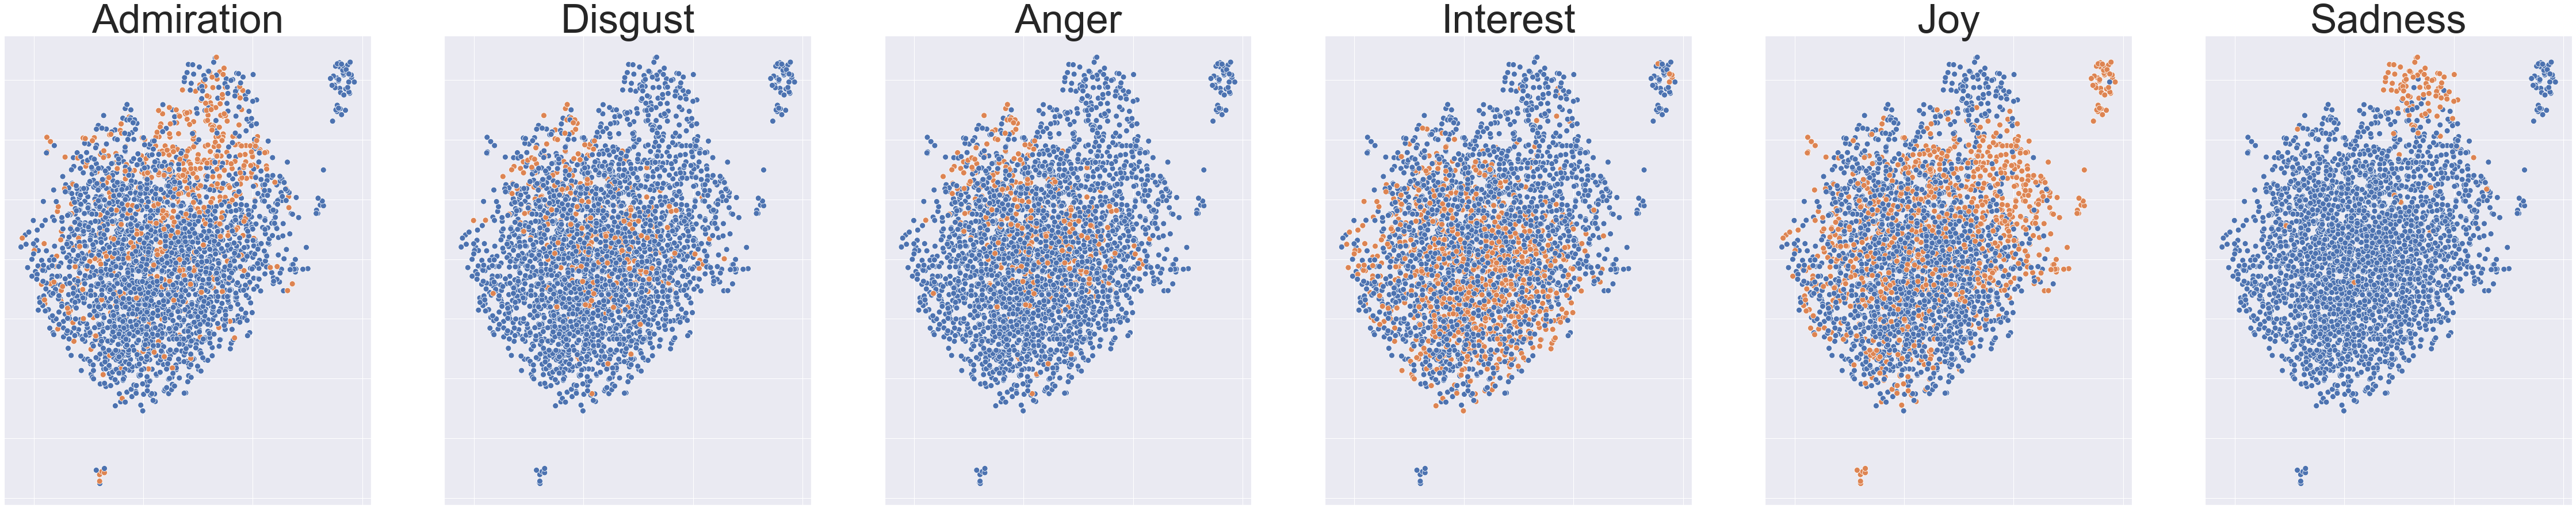

In [18]:
fig, axes = plt.subplots(1, 6, figsize=(80,15))

for emot, ax in zip(emot_ans, axes.ravel()):
    
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=emots_dict[emot], s=100,ax=ax, legend=False)
    ax.set_title(emot, fontsize=70)
    ax.set(xticklabels=[], yticklabels=[])
plt.savefig('bt_emots.png',bbox_inches='tight', pad_inches=0,format='png')

In [ ]:
# inds = np.where(embedding[:,0]<12)[0]
# e2 = embedding[inds]

In [ ]:
# sns.scatterplot(
#     x=e2[:, 0],
#     y=e2[:, 1],
#     hue=[party[i] for i in inds], s=100, palette={'R': sns.color_palette()[1], 'D': sns.color_palette()[0]})
# plt.title('UMAP projection of Congressional tweets with party as color')
# plt.legend()

In [ ]:
# sns.scatterplot(
#     x=e2[:, 0],
#     y=e2[:, 1],
#     hue=[group[i] for i in inds], s=100, palette={1: sns.color_palette()[2], -1: sns.color_palette()[3]})
# plt.legend()
# plt.title('UMAP projection of Congressional tweets with group affiliation')

In [ ]:
# sns.scatterplot(
#     x=e2[:, 0],
#     y=e2[:, 1],
#     hue=[beh[i] for i in inds], s=100)
# plt.legend()
# plt.title('UMAP projection of Congressional tweets with Behavior')

In [ ]:
# sns.scatterplot(
#     x=e2[:, 0],
#     y=e2[:, 1],
#     hue=[fel[i] for i in inds], s=100)
# plt.legend()
# plt.title('UMAP projection of Congressional tweets with Feeling')

In [ ]:
# sns.scatterplot(
#     x=embedding[:, 0],
#     y=embedding[:, 1],
#     hue=party,
#     style=group, s=100)
# plt.title('UMAP projection of Congressional tweets with party as color and group as shape')
# plt.legend()

In [ ]:
# indices = np.random.choice(cls_tensors.shape[0], 1000, replace=False)
# sample = cls_tensors[indices]

In [ ]:
# tsne_embedding = TSNE(n_components=2).fit_transform(sample)

In [ ]:
# sns.scatterplot(
#     x=tsne_embedding[:, 0],
#     y=tsne_embedding[:, 1],
#     hue=party, s=100)
# plt.title('tSNE projection of Congressional tweets with party as color')
# plt.legend()

In [ ]:
# sns.scatterplot(
#     x=tsne_embedding[:, 0],
#     y=tsne_embedding[:, 1],
#     hue=group, s=100)
# plt.title('tSNE projection of Congressional tweets with group as color')
# plt.legend()

In [ ]:
for i, g in enumerate(group):
        if (embedding[i, 0] < 5.5) and (embedding[i, 1] > 9):
            print(tweetso[i])

In [ ]:
for i, g in enumerate(group):
        if (embedding[i, 0] > 12):
            print(tweetso[i])

In [ ]:
maj_df